In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install monai nibabel numpy scipy matplotlib tqdm SimpleITK
!pip install neuroHarmonize nilearn tqdm
!pip install neuroHarmonize neuroCombat

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 61.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neuroCombat: filename=neuroCombat-0.2.12-py3-none-any.whl size=6353 sha256=642428bcfb4ce43e0e9c8e774b4b1c4e42ebde7a590025dbfc2342e628e1c297
  Stored in directory: /root/.cache/pip/wheels/be/6a/95/9d827c0f3cc23854b5fbd00fbc8a052d492538dc16bd20f7a2
Successfully built neuroCombat


In [ ]:

import torch
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from nilearn import datasets, image, masking
from tqdm import tqdm
from neuroHarmonize import harmonizationLearn
import seaborn as sns
import imageio
import tensorflow as tf
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training 2D version of Pix2Pix

In [ ]:
# last_ckpt = ckpt_manager.latest_checkpoint
# start_epoch = int(last_ckpt.split("-")[-1])
# print("Resuming from epoch", start_epoch)

In [ ]:


import os
from glob import glob
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Parameters
IMG_SIZE = 256
BATCH_SIZE = 1
EPOCHS = 40
LAMBDA = 100
CHECKPOINT_DIR = "/content/drive/MyDrive/finalT1T2Data/checkpoints/harmonizedData"
SAMPLES_DIR = "/content/drive/MyDrive/finalT1T2Data/samples/harmonizedData"


# Load + preprocess 2D images
def load_image_2d(path):
    img = Image.open(path).convert("L")                       # grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)


def load_2d_dataset(t1_dir, t2_dir):
    t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
    t2_paths = sorted(glob(os.path.join(t2_dir, "*")))
    print(len(t1_paths))
    print(len(t2_paths))
    assert len(t1_paths) == len(t2_paths), "T1/T2 count mismatch"

    X, Y = [], []
    print("Loading 2D slices...")
    for p1, p2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
        X.append(load_image_2d(p1))
        Y.append(load_image_2d(p2))

    X = np.stack(X, axis=0)
    Y = np.stack(Y, axis=0)
    print(f"Loaded {X.shape[0]} image pairs")
    return X, Y


# TF Dataset
def make_tf_dataset(X, Y):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


# pix2pix generator & discriminator
def down(nf, size, bn=True):
    init = tf.random_normal_initializer(0., 0.02)
    seq = tf.keras.Sequential()
    seq.add(tf.keras.layers.Conv2D(nf, size, strides=2, padding="same",
                                   kernel_initializer=init, use_bias=not bn))
    if bn:
        seq.add(tf.keras.layers.BatchNormalization())
    seq.add(tf.keras.layers.LeakyReLU())
    return seq


def up(nf, size, dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    seq = tf.keras.Sequential()
    seq.add(tf.keras.layers.Conv2DTranspose(nf, size, strides=2, padding="same",
                                            kernel_initializer=init, use_bias=False))
    seq.add(tf.keras.layers.BatchNormalization())
    if dropout:
        seq.add(tf.keras.layers.Dropout(0.5))
    seq.add(tf.keras.layers.ReLU())
    return seq


def build_generator():
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    down_layers = [
        down(64, 4, bn=False),
        down(128, 4),
        down(256, 4),
        down(512, 4),
        down(512, 4),
    ]
    up_layers = [
        up(512, 4, dropout=True),
        up(256, 4),
        up(128, 4),
        up(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2,
                                           padding="same",
                                           kernel_initializer=init,
                                           activation="tanh")
    x = inp
    skips = []
    for layer in down_layers:
        x = layer(x)
        skips.append(x)

    skips = list(reversed(skips[:-1]))

    for up_layer, skip in zip(up_layers, skips):
        x = up_layer(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inp, outputs=x)


def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    tar = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    x = tf.keras.layers.Concatenate()([inp, tar])
    x = down(64, 4, bn=False)(x)
    x = down(128, 4)(x)
    x = down(256, 4)(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding="same",
                               kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding="same",
                               kernel_initializer=init)(x)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)


# Loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(disc_fake, gen_output, target):
    adv = bce(tf.ones_like(disc_fake), disc_fake)
    l1 = tf.reduce_mean(tf.abs(target - gen_output))
    return adv + LAMBDA * l1, adv, l1

def disc_loss(real, fake):
    return bce(tf.ones_like(real), real) + bce(tf.zeros_like(fake), fake)


# Training
generator = build_generator()
discriminator = build_discriminator()
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# # Rebuild model
# G_AtoB = build_generator()
# G_BtoA = build_generator()
# D_A = build_discriminator()
# D_B = build_discriminator()

# # optimizers
# G_AtoB_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# G_BtoA_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# D_A_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# D_B_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# # load checkpoint
# ckpt = tf.train.Checkpoint(
#     G_AtoB=G_AtoB,
#     G_BtoA=G_BtoA,
#     D_A=D_A,
#     D_B=D_B,
#     G_AtoB_optimizer=G_AtoB_optimizer,
#     G_BtoA_optimizer=G_BtoA_optimizer,
#     D_A_optimizer=D_A_optimizer,
#     D_B_optimizer=D_B_optimizer
# )

# ckpt_manager = tf.train.CheckpointManager(ckpt, "/content/drive/MyDrive/finalT1T2Data/checkpoints/harmonizedData", max_to_keep=5)


# ckpt_path = os.path.join(CHECKPOINT_DIR, "ckpt-21")

# if ckpt_manager.latest_checkpoint:
#     print("Restoring from:", ckpt_path)
#     ckpt.restore(ckpt_path).expect_partial()
# else:
#     print("No checkpoint found. Starting from scratch.")
#     ckpt = tf.train.Checkpoint(generator=generator,
#                               discriminator=discriminator,
#                               g_opt=g_opt,
#                               d_opt=d_opt)
start_epoch = 1
ckpt = tf.train.Checkpoint(generator=generator,
                              discriminator=discriminator,
                              g_opt=g_opt,
                              d_opt=d_opt)
manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

os.makedirs(SAMPLES_DIR, exist_ok=True)


@tf.function
def train_step(x, y):
    with tf.GradientTape(persistent=True) as tape:
        fake = generator(x, training=True)
        real_out = discriminator([x, y], training=True)
        fake_out = discriminator([x, fake], training=True)

        g_total, g_adv, g_l1 = gen_loss(fake_out, fake, y)
        d_total = disc_loss(real_out, fake_out)

    g_grads = tape.gradient(g_total, generator.trainable_variables)
    d_grads = tape.gradient(d_total, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    return g_total, d_total


def save_sample(x, y, epoch):
    pred = generator(x, training=False)[0].numpy()
    inp = (x[0].numpy() * 0.5) + 0.5
    tar = (y[0].numpy() * 0.5) + 0.5
    pred = (pred * 0.5) + 0.5

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(inp.squeeze(), cmap="gray"); axs[0].set_title("T1 Input")
    axs[1].imshow(pred.squeeze(), cmap="gray"); axs[1].set_title("Predicted T2")
    axs[2].imshow(tar.squeeze(), cmap="gray"); axs[2].set_title("True T2")
    for ax in axs: ax.axis("off")

    fname = os.path.join(SAMPLES_DIR, f"epoch_{epoch:03d}.png")
    plt.savefig(fname, bbox_inches="tight")
    plt.close(fig)


def train(ds):
    print("Starting Training...")
    for epoch in range(start_epoch, EPOCHS + 1):
        for x, y in ds:
            g_loss, d_loss = train_step(x, y)

        if epoch % 2 == 0:
            save_sample(x, y, epoch)

        manager.save()
        print(f"Epoch {epoch}/{EPOCHS}: gen={g_loss.numpy():.4f}, disc={d_loss.numpy():.4f}")


# MAIN
if __name__ == "__main__":
    t1_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTrain/T1"
    t2_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTrain/T2"

    X, Y = load_2d_dataset(t1_dir, t2_dir)
    ds = make_tf_dataset(X, Y)

    train(ds)

    generator.save(os.path.join(SAMPLES_DIR, "generator_final_harmonized.h5"))
    print("Saved model.")


176
176
Loading 2D slices...


100%|██████████| 176/176 [00:03<00:00, 49.10it/s]


Loaded 176 image pairs
Starting Training...
Epoch 1/40: gen=13.5776, disc=1.5127
Epoch 2/40: gen=14.1193, disc=1.3628
Epoch 3/40: gen=14.5309, disc=1.4458
Epoch 4/40: gen=8.8471, disc=1.6248
Epoch 5/40: gen=9.2304, disc=0.9149
Epoch 6/40: gen=15.4306, disc=0.7941
Epoch 7/40: gen=14.1645, disc=0.7439
Epoch 8/40: gen=10.6681, disc=1.0250
Epoch 9/40: gen=10.0358, disc=1.1819
Epoch 10/40: gen=10.5383, disc=0.9621
Epoch 11/40: gen=10.8901, disc=1.3490
Epoch 12/40: gen=8.8053, disc=1.1754
Epoch 13/40: gen=8.8293, disc=0.9923
Epoch 14/40: gen=9.6688, disc=1.7786
Epoch 15/40: gen=11.8938, disc=0.8637
Epoch 16/40: gen=9.1996, disc=0.8736
Epoch 17/40: gen=8.2156, disc=0.9093
Epoch 18/40: gen=7.3764, disc=1.4429
Epoch 19/40: gen=9.2644, disc=1.1126
Epoch 20/40: gen=7.7917, disc=1.2034
Epoch 21/40: gen=6.5440, disc=1.5837
Epoch 22/40: gen=6.8928, disc=1.3940
Epoch 23/40: gen=6.3006, disc=1.3044
Epoch 24/40: gen=7.3306, disc=1.2638
Epoch 25/40: gen=7.6880, disc=0.6358
Epoch 26/40: gen=6.1631, disc=

Epoch 40/40: gen=5.8400, disc=1.0321
Saved model.


In [ ]:
#train predictions


model_path = "/content/drive/MyDrive/finalT1T2Data/samples/harmonizedData/generator_final_harmonized.h5"   # change if needed
generator = tf.keras.models.load_model(model_path)
print("Loaded generator.")



Loaded generator.


In [ ]:
from PIL import Image

IMG_SIZE = 256

t1_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTrain/T1"
t2_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTrain/T2"
out_dir = "/content/drive/MyDrive/finalT1T2Data/trainPredictionsHarmonized"   # where to save generated T2 images
os.makedirs(out_dir, exist_ok=True)

t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
t2_paths = sorted(glob(os.path.join(t2_dir, "*")))

def load_image_2d(path):
    img = Image.open(path).convert("L")                       # grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)

def denormalize(x):
    x = (x + 1.0) / 2.0         # [-1,1] → [0,1]
    x = (x * 255).clip(0, 255)
    return x.astype(np.uint8)

def compute_ssim(pred, target):
    pred_tf = tf.convert_to_tensor(pred, dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target, dtype=tf.float32)

    ssim_val = tf.image.ssim(pred_tf, target_tf, max_val=2.0)

    return float(ssim_val.numpy())

ssim_scores = []
for p_t1, p_t2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
    x = load_image_2d(p_t1)
    y_true = load_image_2d(p_t2)

    x_batch = x[None, ...]

    # Run generator
    y_pred = generator(x_batch, training=False).numpy()[0]

    # Compute SSIM
    ssim = compute_ssim(y_pred, y_true)
    ssim_scores.append(ssim)

    # Save prediction
    out_path = os.path.join(out_dir, os.path.basename(p_t1))
    Image.fromarray(((y_pred[...,0] + 1) * 127.5).astype(np.uint8)).save(out_path)

print("DONE! Predictions saved to:", out_dir)

print("Mean SSIM:", np.mean(ssim_scores))
print("Median SSIM:", np.median(ssim_scores))


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)
100%|██████████| 176/176 [00:15<00:00, 11.52it/s]

DONE! Predictions saved to: /content/drive/MyDrive/finalT1T2Data/trainPredictionsHarmonized
Mean SSIM: 0.824851393699646
Median SSIM: 0.8291166424751282


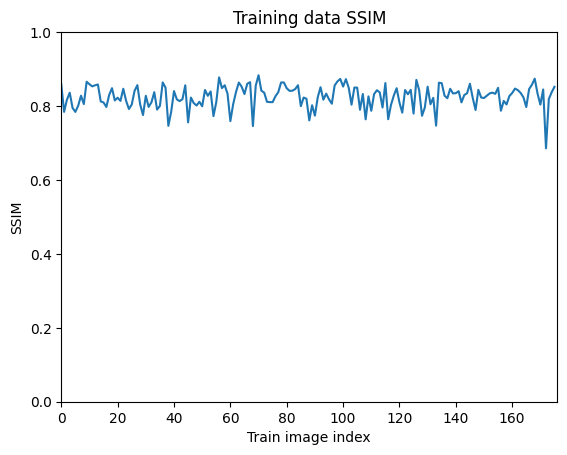

In [ ]:
plt.plot(ssim_scores)
plt.xlabel("Train image index")
plt.ylabel("SSIM")
plt.title("Training data SSIM")
plt.xlim(0, len(ssim_scores))
plt.ylim(0, 1)
plt.show()

Calculating testing accuracy

In [ ]:
from PIL import Image

IMG_SIZE = 256

t1_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTest/T1"
t2_dir = "/content/drive/MyDrive/finalT1T2Data/harmonizedTest/T2"
out_dir = "/content/drive/MyDrive/finalT1T2Data/testPredictionsHarmonized"   # where to save generated T2 images
os.makedirs(out_dir, exist_ok=True)

t1_paths = sorted(glob(os.path.join(t1_dir, "*")))
t2_paths = sorted(glob(os.path.join(t2_dir, "*")))

def load_image_2d(path):
    img = Image.open(path).convert("L")                       # grayscale
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)

    # Normalize to [-1,1]
    arr = arr / 255.0
    arr = (arr * 2.0) - 1.0
    return arr[..., None]  # (H, W, 1)

def denormalize(x):
    x = (x + 1.0) / 2.0         # [-1,1] → [0,1]
    x = (x * 255).clip(0, 255)
    return x.astype(np.uint8)

def compute_ssim(pred, target):
    pred_tf = tf.convert_to_tensor(pred, dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target, dtype=tf.float32)

    ssim_val = tf.image.ssim(pred_tf, target_tf, max_val=2.0)

    return float(ssim_val.numpy())

ssim_scores = []
for p_t1, p_t2 in tqdm(zip(t1_paths, t2_paths), total=len(t1_paths)):
    x = load_image_2d(p_t1)
    y_true = load_image_2d(p_t2)
    x_batch = x[None, ...]

    # Run generator
    y_pred = generator(x_batch, training=False).numpy()[0]

    # Compute SSIM
    ssim = compute_ssim(y_pred, y_true)
    ssim_scores.append(ssim)

    # Save prediction
    out_path = os.path.join(out_dir, os.path.basename(p_t1))
    Image.fromarray(((y_pred[...,0] + 1) * 127.5).astype(np.uint8)).save(out_path)

print("DONE! Predictions saved to:", out_dir)

print("Mean SSIM:", np.mean(ssim_scores))
print("Median SSIM:", np.median(ssim_scores))


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)
100%|██████████| 46/46 [01:52<00:00,  2.44s/it]

DONE! Predictions saved to: /content/drive/MyDrive/finalT1T2Data/testPredictionsHarmonized
Mean SSIM: 0.6184512454530467
Median SSIM: 0.6130179166793823


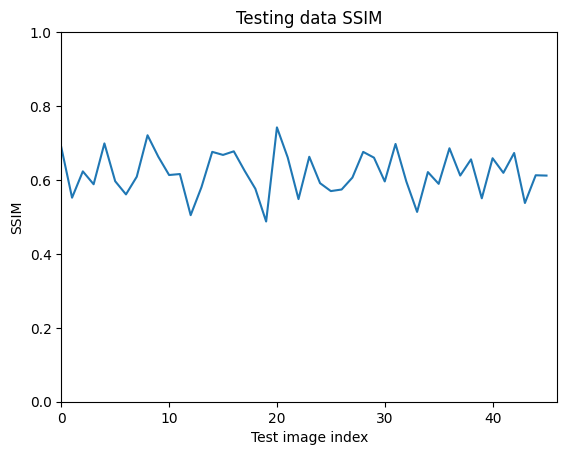

In [ ]:
plt.plot(ssim_scores)
plt.xlabel("Test image index")
plt.ylabel("SSIM")
plt.title("Testing data SSIM")
plt.xlim(0, len(ssim_scores))
plt.ylim(0, 1)
plt.show()

Training ResNet18 to predict site

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

print(device)

cuda


In [ ]:
train_data_dir = "/content/drive/MyDrive/finalT1T2Data/trainPredictionsHarmonized"
test_data_dir = "/content/drive/MyDrive/finalT1T2Data/testPredictionsHarmonized"

In [ ]:
train_prediction_files = sorted([f for f in os.listdir(train_data_dir)])
hh_train_predictions_names = []
guys_train_predictions_names= []
for f in train_prediction_files:
  f_full_name = os.path.join(train_data_dir, f)
  if f_full_name.split('_')[1] == 'HH':
    hh_train_predictions_names.append(f_full_name)
  else:
    guys_train_predictions_names.append(f_full_name)

In [ ]:
test_prediction_files = sorted([f for f in os.listdir(test_data_dir)])
hh_test_predictions_names = []
guys_test_predictions_names= []
for f in test_prediction_files:
  f_full_name = os.path.join(test_data_dir, f)
  if f_full_name.split('_')[1] == 'HH':
    hh_test_predictions_names.append(f_full_name)
  else:
    guys_test_predictions_names.append(f_full_name)

In [ ]:
HH_files=hh_train_predictions_names
guys_files=guys_train_predictions_names

class scanSite(Dataset):
    def __init__(self, HH_files, guys_files):
        self.fpaths = HH_files + guys_files
        self.normalize = transforms.Normalize(mean=[0.449], std=[0.226])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('_')[1]=="HH" for fpath in self.fpaths] #HH=1, Guys=0
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

data = scanSite(hh_train_predictions_names, guys_train_predictions_names)

In [ ]:
data.__len__()

176

In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = scanSite(hh_train_predictions_names, guys_train_predictions_names)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = scanSite(hh_test_predictions_names, guys_test_predictions_names)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(20):

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

All losses and accuracies are for each epoch
 epoch 1/5, Training Loss: 0.6486734867095947, Training Accuracy: 0.54375, Validation Accuracy: 0.5625
 epoch 2/5, Training Loss: 0.5328953206539154, Training Accuracy: 0.5375, Validation Accuracy: 0.59375
 epoch 3/5, Training Loss: 0.5671079993247986, Training Accuracy: 0.55625, Validation Accuracy: 0.5
 epoch 4/5, Training Loss: 0.48872860074043273, Training Accuracy: 0.7625, Validation Accuracy: 0.46875
 epoch 5/5, Training Loss: 0.4166988134384155, Training Accuracy: 0.775, Validation Accuracy: 0.5625
 epoch 6/5, Training Loss: 0.3569808900356293, Training Accuracy: 0.8375, Validation Accuracy: 0.625
 epoch 7/5, Training Loss: 0.35947455167770387, Training Accuracy: 0.8625, Validation Accuracy: 0.65625
 epoch 8/5, Training Loss: 0.30958848893642427, Training Accuracy: 0.8875, Validation Accuracy: 0.65625
 epoch 9/5, Training Loss: 0.2866716146469116, Training Accuracy: 0.9, Validation Accuracy: 0.625
 epoch 10/5, Training Loss: 0.2689742

/tmp/ipython-input-1028209405.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


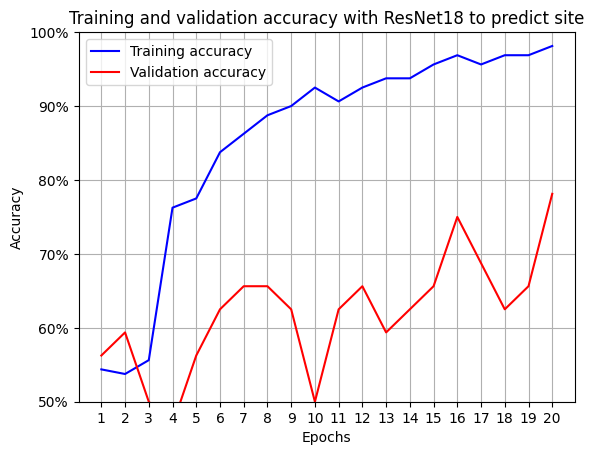

In [ ]:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 to predict site')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()